# Video segmentation and tracking with SAM 3

### This notebook demonstrates how to use SAM 3 for interactive video segmentation and dense tracking. It covers the following capabilities:

- **Text prompts**: Using natural language descriptions to segment objects (e.g., "person", "face", "visual")
- **Point prompts**: Adding positive/negative clicks to segment and refine objects
- **Box prompts**: Using bounding boxes combined with text for precise object localization
- **Interactive refinement**: Adding clicks on any frame to improve segmentation quality

#### We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 


# <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam3/blob/main/notebooks/sam3_video_predictor_example.ipynb">
#   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
# </a>


## Set-up

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch

# use all available GPUs on the machine
gpus_to_use = range(torch.cuda.device_count())

# # use only a single GPU
# gpus_to_use = [torch.cuda.current_device()]

In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from utils import visualize_formatted_frame_output, prepare_masks_for_visualization, visualize_prompt_overlay, show_points, draw_box_on_image

# helper functions
def propagate_in_video(predictor, session_id):

    # we will just propagate from frame 0 to the end of the video
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]

    return outputs_per_frame

def abs_to_rel_coords(coords, IMG_WIDTH, IMG_HEIGHT, coord_type='point'):
    """Convert absolute coordinates to relative coordinates (0-1 range)

    Args:
        coords: List of coordinates
        coord_type: 'point' for [x, y] or 'box' for [x, y, w, h]
    """
    if coord_type == 'point':
        return [[x / IMG_WIDTH, y / IMG_HEIGHT] for x, y in coords]
    elif coord_type == 'box':
        return [[x / IMG_WIDTH, y / IMG_HEIGHT, w / IMG_WIDTH, h / IMG_HEIGHT] for x, y, w, h in coords]
    else:
        raise ValueError(f"Unknown coord_type: {coord_type}")


Converting 5000 RGB samples to LAB color space...
Conversion to LAB complete.
Fitting KMeans with 128 clusters on 5000 samples...
KMeans fitting complete.


In [4]:
from sam3.model.sam3_video_predictor import Sam3VideoPredictorMultiGPU

sam3_root = "/home/marksm/sam3"
sys.path.append(f"{sam3_root}/examples")

# checkpoint_file = f"{sam3_root}/assets/checkpoints/sam3_video_model_only.pt"
checkpoint_file = "/checkpoint/sam3/haithamkhedr/checkpoints/sam3_dense/sam3_v2_rc2.pt"
has_presence_token = True
geo_encoder_use_img_cross_attn = True
predictor = Sam3VideoPredictorMultiGPU(
    checkpoint_path=checkpoint_file,
    has_presence_token=has_presence_token,
    geo_encoder_use_img_cross_attn=geo_encoder_use_img_cross_attn,
    gpus_to_use=gpus_to_use,
)

/checkpoint/sam3/ronghanghu/anaconda3/envs/onevision_sam3/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
INFO 2025-10-10 05:05:30,356 337506 sam3_video_predictor.py: 279: using the following GPU IDs: [0, 1, 2, 3, 4, 5, 6, 7]
INFO 2025-10-10 05:05:30,357 337506 sam3_video_predictor.py: 295: 


	*** START loading model on all ranks ***


INFO 2025-10-10 05:05:30,357 337506 sam3_video_predictor.py: 297: loading model on rank=0 with world_size=8 -- this could take a while ...


Enabled the use of perflib.


INFO 2025-10-10 05:05:36,259 337506 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2025-10-10 05:05:38,959 337506 sam3_video_predictor.py: 299: loading model on rank=0 with world_size=8 -- DONE locally
INFO 2025-10-10 05:05:38,960 337506 sam3_video_predictor.py: 356: spawning 7 worker processes
/checkpoint/sam3/ronghanghu/anaconda3/envs/onevision_sam3/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/checkpoint/sam3/ronghanghu/anaconda3/envs/onevision_sam3/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/checkpoint/sam3/ron

Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.


INFO 2025-10-10 05:05:44,857 338309 sam3_video_predictor.py: 440: starting worker process rank=1 with world_size=8


Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.


INFO 2025-10-10 05:05:45,146 338312 sam3_video_predictor.py: 440: starting worker process rank=4 with world_size=8
INFO 2025-10-10 05:05:45,215 338311 sam3_video_predictor.py: 440: starting worker process rank=3 with world_size=8
INFO 2025-10-10 05:05:45,677 338310 sam3_video_predictor.py: 440: starting worker process rank=2 with world_size=8
INFO 2025-10-10 05:05:45,815 338309 sam3_video_predictor.py: 297: loading model on rank=1 with world_size=8 -- this could take a while ...
INFO 2025-10-10 05:05:45,989 338311 sam3_video_predictor.py: 297: loading model on rank=3 with world_size=8 -- this could take a while ...
INFO 2025-10-10 05:05:46,022 338312 sam3_video_predictor.py: 297: loading model on rank=4 with world_size=8 -- this could take a while ...
INFO 2025-10-10 05:05:46,034 338314 sam3_video_predictor.py: 440: starting worker process rank=6 with world_size=8
INFO 2025-10-10 05:05:46,057 338315 sam3_video_predictor.py: 440: starting worker process rank=7 with world_size=8
INFO 202

NCCL version 2.26.2+cuda12.2

[2025-10-10 05:07:11] h200-061-117:337506:339459 [0] configure_nvls_option:287 NCCL WARN NET/OFI Could not find ncclGetVersion symbol

[2025-10-10 05:07:11] h200-061-117:338315:339460 [7] configure_nvls_option:287 NCCL WARN NET/OFI Could not find ncclGetVersion symbol

[2025-10-10 05:07:11] h200-061-117:338309:339461 [1] configure_nvls_option:287 NCCL WARN NET/OFI Could not find ncclGetVersion symbol

[2025-10-10 05:07:11] h200-061-117:338311:339462 [3] configure_nvls_option:287 NCCL WARN NET/OFI Could not find ncclGetVersion symbol

[2025-10-10 05:07:11] h200-061-117:338310:339465 [2] configure_nvls_option:287 NCCL WARN NET/OFI Could not find ncclGetVersion symbol

[2025-10-10 05:07:11] h200-061-117:338314:339466 [6] configure_nvls_option:287 NCCL WARN NET/OFI Could not find ncclGetVersion symbol

[2025-10-10 05:07:11] h200-061-117:338313:339464 [5] configure_nvls_option:287 NCCL WARN NET/OFI Could not find ncclGetVersion symbol

[2025-10-10 05:07:11] h20

INFO 2025-10-10 05:07:13,972 337506 sam3_video_predictor.py: 413: started NCCL process group on rank=0 with world_size=8
INFO 2025-10-10 05:07:13,972 338312 sam3_video_predictor.py: 413: started NCCL process group on rank=4 with world_size=8
INFO 2025-10-10 05:07:13,972 338313 sam3_video_predictor.py: 413: started NCCL process group on rank=5 with world_size=8
INFO 2025-10-10 05:07:13,972 338314 sam3_video_predictor.py: 413: started NCCL process group on rank=6 with world_size=8
INFO 2025-10-10 05:07:13,972 338310 sam3_video_predictor.py: 413: started NCCL process group on rank=2 with world_size=8
INFO 2025-10-10 05:07:13,972 338311 sam3_video_predictor.py: 413: started NCCL process group on rank=3 with world_size=8
INFO 2025-10-10 05:07:13,972 338309 sam3_video_predictor.py: 413: started NCCL process group on rank=1 with world_size=8
INFO 2025-10-10 05:07:13,972 338315 sam3_video_predictor.py: 413: started NCCL process group on rank=7 with world_size=8
INFO 2025-10-10 05:07:13,973 337

### Loading an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

In [5]:
# this video has 6 objects
video_frames_dir = f"{sam3_root}/assets/videos/0001"
prompt_text_str = "person"

# this video has ~80 objects
# video_frames_dir = "/checkpoint/sam3/shared/webdemo/data/ta/static/gallery/selected_examples/0018/rgb"
# prompt_text_str = "horse"

In [6]:
# load "image_files" for visualization purposes (they are not used by the model)
image_files = glob.glob(os.path.join(video_frames_dir, "*.jpg"))
try:
    # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
    image_files.sort(key=lambda p: int(os.path.splitext(os.path.basename(p))[0]))
except ValueError:
    # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
    print(
        f'frame names are not in "<frame_index>.jpg" format: {image_files[:5]=}, '
        f"falling back to lexicographic sort."
    )
    image_files.sort()

## Running inference
### Opening an inference session on this video
SAM 3 requires stateful inference for interactive video segmentation, so we need to initialize an **inference session** on this video.

During initialization, it loads all the JPEG frames in the video directory and stores their features in the session state.

In [7]:
response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_frames_dir,
    )
)
session_id = response["session_id"]

INFO 2025-10-10 05:07:14,615 338314 sam3_video_predictor.py: 469: worker rank=6 received request request['type']='start_session'
INFO 2025-10-10 05:07:14,616 338311 sam3_video_predictor.py: 469: worker rank=3 received request request['type']='start_session'
INFO 2025-10-10 05:07:14,617 338315 sam3_video_predictor.py: 469: worker rank=7 received request request['type']='start_session'
INFO 2025-10-10 05:07:14,681 338309 sam3_video_predictor.py: 469: worker rank=1 received request request['type']='start_session'
INFO 2025-10-10 05:07:14,681 338310 sam3_video_predictor.py: 469: worker rank=2 received request request['type']='start_session'
INFO 2025-10-10 05:07:14,681 338313 sam3_video_predictor.py: 469: worker rank=5 received request request['type']='start_session'
INFO 2025-10-10 05:07:14,840 338312 sam3_video_predictor.py: 469: worker rank=4 received request request['type']='start_session'
frame loading (JPEG) [rank=4]:   0%|          | 0/270 [00:00<?, ?it/s]

frame loading (JPEG) [rank=0]:   0%|          | 0/270 [00:00<?, ?it/s]

frame loading (JPEG) [rank=6]: 100%|██████████| 270/270 [01:29<00:00,  3.02it/s]
INFO 2025-10-10 05:08:44,366 338312 sam3_video_predictor.py: 121: started new session 8e982d6d-1d49-4296-98a4-c0e413a62a8a; live sessions: ['8e982d6d-1d49-4296-98a4-c0e413a62a8a' (270 frames)], GPU memory: 5094 MiB used and 5198 MiB reserved (max over time: 5094 MiB used and 5198 MiB reserved); torch: 2.7.1+cu126 with CUDA arch ['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90'], GPU device: _CudaDeviceProperties(name='NVIDIA H200', major=9, minor=0, total_memory=143186MB, multi_processor_count=132, uuid=a8bd39f9-4d30-1097-c1de-3bb62ce5a9d0, L2_cache_size=60MB)
frame loading (JPEG) [rank=1]: 100%|██████████| 270/270 [01:29<00:00,  3.02it/s]
INFO 2025-10-10 05:08:44,543 337506 sam3_video_predictor.py: 121: started new session 8e982d6d-1d49-4296-98a4-c0e413a62a8a; live sessions: ['8e982d6d-1d49-4296-98a4-c0e413a62a8a' (270 frames)], GPU memory: 5094 MiB used and 5198 MiB reserved (max over time: 

## Video promptable concept segmentation with text

Using SAM 3 you can describe objects using natural language,

and the model will automatically detect and track all instances of that object throughout the video.

### Adding a text prompt on frame 0 and propagation throughout the video

Note that the first call might be slower due to setting up buffers. **You can rerun all the cells below when measuring speed.**

In [8]:
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

INFO 2025-10-10 05:08:44,865 337506 sam3_video_predictor.py: 210: clear all inputs across the video in session 8e982d6d-1d49-4296-98a4-c0e413a62a8a
INFO 2025-10-10 05:08:44,865 338311 sam3_video_predictor.py: 469: worker rank=3 received request request['type']='reset_session'
INFO 2025-10-10 05:08:44,865 338311 sam3_video_predictor.py: 210: clear all inputs across the video in session 8e982d6d-1d49-4296-98a4-c0e413a62a8a
INFO 2025-10-10 05:08:44,866 338313 sam3_video_predictor.py: 469: worker rank=5 received request request['type']='reset_session'
INFO 2025-10-10 05:08:44,866 338313 sam3_video_predictor.py: 210: clear all inputs across the video in session 8e982d6d-1d49-4296-98a4-c0e413a62a8a
INFO 2025-10-10 05:08:44,866 338314 sam3_video_predictor.py: 469: worker rank=6 received request request['type']='reset_session'
INFO 2025-10-10 05:08:44,866 338314 sam3_video_predictor.py: 210: clear all inputs across the video in session 8e982d6d-1d49-4296-98a4-c0e413a62a8a
INFO 2025-10-10 05:08

### Adding a text prompt

Here we use the text prompt "person" to detect all people in the video. 

SAM 3 will automatically identify multiple person instances and assign each a unique object ID.

In [9]:
frame_idx = 0  # add a text prompt on frame 0
response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
out = response["outputs"]

INFO 2025-10-10 05:08:45,053 337506 sam3_video_predictor.py: 141: add prompt on frame 0 in session 8e982d6d-1d49-4296-98a4-c0e413a62a8a: text='person', points=None, point_labels=None, clear_old_points=True, bounding_boxes=None, bounding_box_labels=None, clear_old_boxes=True
INFO 2025-10-10 05:08:45,054 338311 sam3_video_predictor.py: 469: worker rank=3 received request request['type']='add_prompt'
INFO 2025-10-10 05:08:45,054 338311 sam3_video_predictor.py: 141: add prompt on frame 0 in session 8e982d6d-1d49-4296-98a4-c0e413a62a8a: text='person', points=None, point_labels=None, clear_old_points=True, bounding_boxes=None, bounding_box_labels=None, clear_old_boxes=True
INFO 2025-10-10 05:08:45,054 338313 sam3_video_predictor.py: 469: worker rank=5 received request request['type']='add_prompt'
INFO 2025-10-10 05:08:45,054 338311 sam3_video_inference.py: 865: Running add_prompt on frame 0
INFO 2025-10-10 05:08:45,054 338312 sam3_video_predictor.py: 469: worker rank=4 received request reque

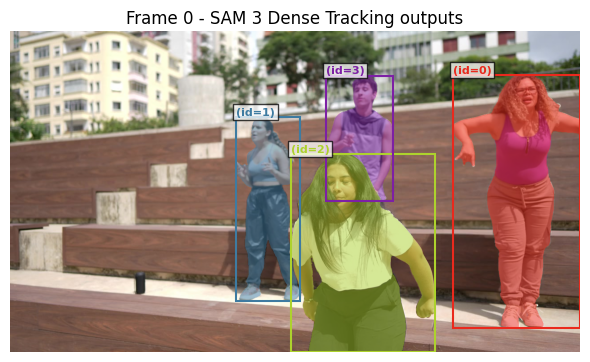

In [10]:
plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    image_files,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

INFO 2025-10-10 05:08:54,765 337506 sam3_video_predictor.py: 171: propagate in video in session 8e982d6d-1d49-4296-98a4-c0e413a62a8a: propagation_direction='both', start_frame_idx=None, max_frame_num_to_track=None
INFO 2025-10-10 05:08:54,766 338310 sam3_video_predictor.py: 469: worker rank=2 received request request['type']='propagate_in_video'
INFO 2025-10-10 05:08:54,766 338313 sam3_video_predictor.py: 469: worker rank=5 received request request['type']='propagate_in_video'
INFO 2025-10-10 05:08:54,767 338310 sam3_video_predictor.py: 171: propagate in video in session 8e982d6d-1d49-4296-98a4-c0e413a62a8a: propagation_direction='both', start_frame_idx=None, max_frame_num_to_track=None
INFO 2025-10-10 05:08:54,766 338309 sam3_video_predictor.py: 469: worker rank=1 received request request['type']='propagate_in_video'
INFO 2025-10-10 05:08:54,767 338310 sam3_video_inference.py:1054: Running full VG propagation (reverse=False).
INFO 2025-10-10 05:08:54,767 338309 sam3_video_predictor.py

propagate_in_video:   0%|          | 0/270 [00:00<?, ?it/s]

INFO 2025-10-10 05:09:05,280 338314 sam3_video_inference.py:1054: Running full VG propagation (reverse=True).
INFO 2025-10-10 05:09:05,281 338315 sam3_video_inference.py:1054: Running full VG propagation (reverse=True).
INFO 2025-10-10 05:09:05,281 338314 sam3_video_predictor.py: 204: propagation ended in session 8e982d6d-1d49-4296-98a4-c0e413a62a8a; live sessions: ['8e982d6d-1d49-4296-98a4-c0e413a62a8a' (270 frames)], GPU memory: 7137 MiB used and 9320 MiB reserved (max over time: 8867 MiB used and 9320 MiB reserved)
INFO 2025-10-10 05:09:05,281 338315 sam3_video_predictor.py: 204: propagation ended in session 8e982d6d-1d49-4296-98a4-c0e413a62a8a; live sessions: ['8e982d6d-1d49-4296-98a4-c0e413a62a8a' (270 frames)], GPU memory: 7137 MiB used and 9320 MiB reserved (max over time: 8867 MiB used and 9320 MiB reserved)
INFO 2025-10-10 05:09:05,282 338310 sam3_video_inference.py:1054: Running full VG propagation (reverse=True).
INFO 2025-10-10 05:09:05,282 338312 sam3_video_inference.py:10

propagate_in_video: 0it [00:00, ?it/s]

INFO 2025-10-10 05:09:05,344 337506 sam3_video_predictor.py: 204: propagation ended in session 8e982d6d-1d49-4296-98a4-c0e413a62a8a; live sessions: ['8e982d6d-1d49-4296-98a4-c0e413a62a8a' (270 frames)], GPU memory: 8562 MiB used and 10778 MiB reserved (max over time: 10286 MiB used and 10778 MiB reserved)


frame 0


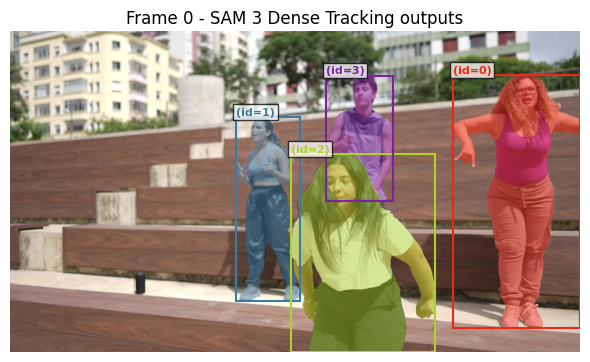

frame 60


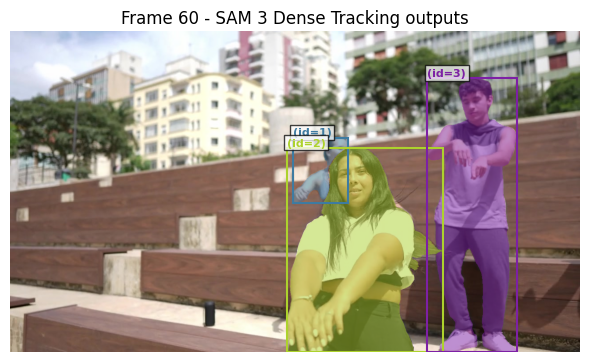

frame 120


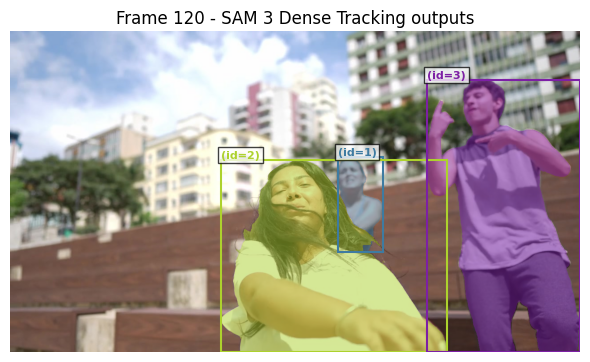

frame 180


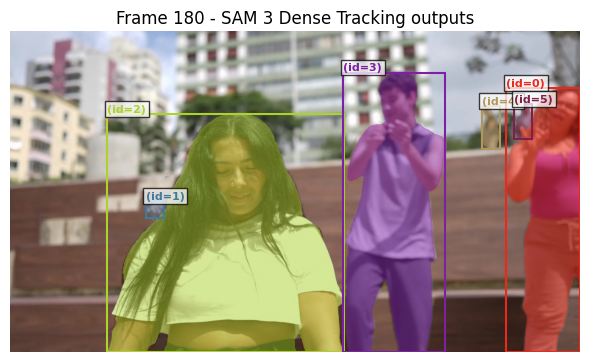

frame 240


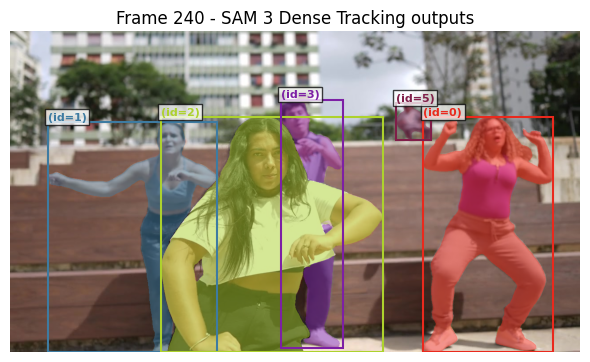

In [11]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(predictor, session_id)

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    print(f"frame {frame_idx}")
    visualize_formatted_frame_output(
        frame_idx,
        image_files,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

###  Adding new objects with point prompts

In addition to text prompts, SAM 3 supports **point prompts** to add specific objects that might not be detected automatically.
Here we add a new object by clicking on a specific location.

Note: label `1` indicates a *positive click (to add a region)* while label `0` indicates a *negative click (to remove a region)*.

#### Get image dimensions for coordinate conversion

We compute the image dimensions once at the beginning and use them throughout for coordinate conversions.

All coordinates in this example are defined in absolute pixel coordinates and then converted to relative coordinates (0-1 range) for the model.

In [12]:
sample_img = Image.open(image_files[0])
IMG_WIDTH, IMG_HEIGHT = sample_img.size
print(f"Image dimensions: {IMG_WIDTH} x {IMG_HEIGHT}")

Image dimensions: 1280 x 720


###  Interactive refinement with point prompts

In addition to using **point prompts** for adding objects, we can use them to refine objects.

This is particularly useful when the initial segmentation from text prompts needs fine adjustments.

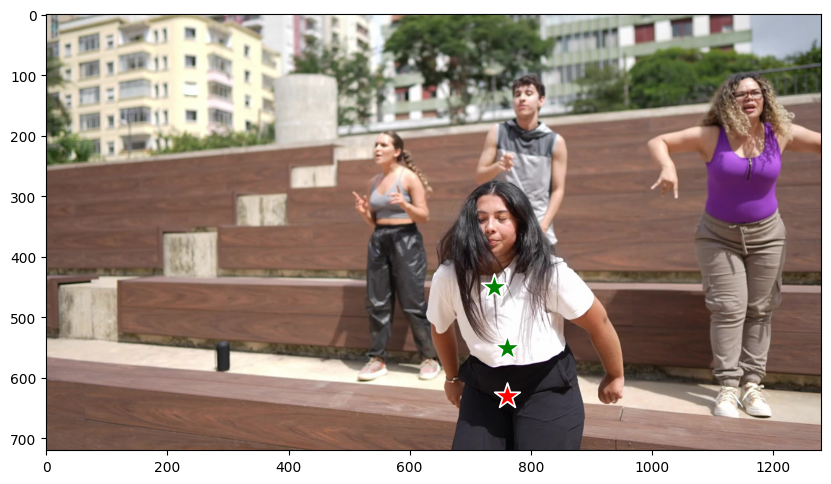

In [13]:
points_abs = [
    [740, 450], #positive click
    [760, 630], #negative click
    [760, 550], #positive click
]
labels = np.array([1,0,1])

frame_idx = 0
refine_obj_id = 2

points_abs = np.array(points_abs)

image = Image.open(image_files[0])
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(points_abs, labels, plt.gca())
plt.axis('on')
plt.show()  


# Convert to relative coordinates for the model
points = np.array(abs_to_rel_coords(points_abs, IMG_WIDTH, IMG_HEIGHT, coord_type='point'))

# convert points and labels to tensors
points_tensor = torch.tensor(points, dtype=torch.float32)
points_labels_tensor = torch.tensor(labels, dtype=torch.int32)

In [14]:
response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        points=points_tensor,
        point_labels=points_labels_tensor,
        obj_id=refine_obj_id,
    )
)

outputs_per_frame = propagate_in_video(predictor, session_id)
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)


vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    print(f"frame {frame_idx}")
    visualize_formatted_frame_output(
        frame_idx,
        image_files,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

INFO 2025-10-10 05:09:11,329 337506 sam3_video_predictor.py: 141: add prompt on frame 0 in session 8e982d6d-1d49-4296-98a4-c0e413a62a8a: text=None, points=tensor([[0.5781, 0.6250],
        [0.5938, 0.8750],
        [0.5938, 0.7639]]), point_labels=tensor([1, 0, 1], dtype=torch.int32), clear_old_points=True, bounding_boxes=None, bounding_box_labels=None, clear_old_boxes=True
INFO 2025-10-10 05:09:11,340 338315 sam3_video_predictor.py: 469: worker rank=7 received request request['type']='add_prompt'
INFO 2025-10-10 05:09:11,341 338315 sam3_video_predictor.py: 141: add prompt on frame 0 in session 8e982d6d-1d49-4296-98a4-c0e413a62a8a: text=None, points=tensor([[0.5781, 0.6250],
        [0.5938, 0.8750],
        [0.5938, 0.7639]]), point_labels=tensor([1, 0, 1], dtype=torch.int32), clear_old_points=True, bounding_boxes=None, bounding_box_labels=None, clear_old_boxes=True
INFO 2025-10-10 05:09:11,342 338313 sam3_video_predictor.py: 469: worker rank=5 received request request['type']='add_pr

  0%|          | 0/2 [00:00<?, ?it/s]

INFO 2025-10-10 05:09:12,919 337506 sam3_video_predictor.py: 204: propagation ended in session 8e982d6d-1d49-4296-98a4-c0e413a62a8a; live sessions: ['8e982d6d-1d49-4296-98a4-c0e413a62a8a' (270 frames)], GPU memory: 11411 MiB used and 12030 MiB reserved (max over time: 11531 MiB used and 12030 MiB reserved)


TypeError: list indices must be integers or slices, not range

### Reset the session

In [ ]:
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

###  Adding new objects with box prompts

In addition to text and point prompts, SAM 3 supports **box prompts** to add objects.

This is particularly useful if we cannot describe a concept, but we can draw a box around it.

#### Adding object via box only prompts

In this example we prompt the model with a concrete step in the video.

In [ ]:
boxes_abs = [
    [190, 365, 89, 80]
]

boxes = abs_to_rel_coords(boxes_abs, IMG_WIDTH, IMG_HEIGHT, 'box')

# we use "visual" as text prompt for a prompt that uses the box only
prompt_text_str = "visual"
frame_idx = 0

image = Image.open(image_files[0])
image_with_box = image
for box in boxes_abs:
    image_with_box = draw_box_on_image(image_with_box, box, (0,255,0))
plt.imshow(image_with_box)
plt.axis('off')  # Hide the axis
plt.show()

response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
        bounding_boxes=boxes,
        bounding_box_labels=[1] * len(boxes),
    )
)

In [ ]:
outputs_per_frame = propagate_in_video(predictor, session_id)
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)


vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    print(f"frame {frame_idx}")
    visualize_formatted_frame_output(
        frame_idx,
        image_files,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

In [ ]:
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

#### Adding object via box and text prompts

In this example we prompt the model with both a text and a box prompt for the face of the person.

In [ ]:
boxes_abs = [
    [520, 200, 90, 40]
]

boxes = abs_to_rel_coords(boxes_abs, IMG_WIDTH, IMG_HEIGHT, 'box')

prompt_text_str = "face"
frame_idx = 0

# visualize the concrete step box prompt
visualize_prompt_overlay(
    frame_idx,
    image_files,
    bounding_boxes=boxes,
    box_labels=[1],
    text_prompt=prompt_text_str,
)


response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
        bounding_boxes=boxes,
        bounding_box_labels=[1] * len(boxes),
    )
)

In [ ]:
outputs_per_frame = propagate_in_video(predictor, session_id)
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)


vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    print(f"frame {frame_idx}")
    visualize_formatted_frame_output(
        frame_idx,
        image_files,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

#### Refine multiple objects simultaneously

SAM 3's most advanced feature is the ability to refine multiple objects simultaneously within the same session.
This is particularly useful for complex scenarios where multiple objects need different types of corrections.

Refine object 0 (face region)

First, we refine the face region using negative and positive points to improve boundary precision.

In [ ]:
points_abs = [
    [580, 250],  # negative point to remove unwanted area
    [570, 220],  # positive point to keep desired area
]

point_labels = np.array([0,1])
frame_idx = 0
object_id = 0


points_abs = np.array(points_abs)

image = Image.open(image_files[0])
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(points_abs, point_labels, plt.gca())
plt.axis('on')
plt.show()  


# Convert to relative coordinates for the model
points = np.array(abs_to_rel_coords(points_abs, IMG_WIDTH, IMG_HEIGHT, coord_type='point'))

# Convert points and labels to tensors
points_tensor = torch.tensor(points, dtype=torch.float32)
labels_tensor = torch.tensor(point_labels, dtype=torch.int32)

response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        points=points_tensor,
        point_labels=labels_tensor,
        obj_id=object_id,
    )
)

In [ ]:
outputs_per_frame = propagate_in_video(predictor, session_id)
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)


vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    print(f"frame {frame_idx}")
    visualize_formatted_frame_output(
        frame_idx,
        image_files,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

Refine object 3 (body region)

Next, we refine the body region using multiple negative points and one positive point for precise con

In [ ]:
points_abs = [
    [740, 450], #positive click
    [760, 630], #negative click
    [760, 550], #positive click,
    [760, 50], #negative click

]
labels = np.array([1,0,1,0])
points_abs = np.array(points_abs)
point_labels = np.array(point_labels)

plt.close('all')
image = Image.open(image_files[0])
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(points_abs, point_labels, plt.gca())
plt.axis('on')
plt.show()  

# Convert to relative coordinates for the model
points = abs_to_rel_coords(points_abs,IMG_WIDTH, IMG_HEIGHT, coord_type='point')

frame_idx = 0
object_id = 3



# Convert points and labels to tensors
points_tensor = torch.tensor(points, dtype=torch.float32)
labels_tensor = torch.tensor(point_labels, dtype=torch.int32)

response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        points=points_tensor,
        point_labels=labels_tensor,
        obj_id=object_id,
    )
)

In [ ]:
outputs_per_frame = propagate_in_video(predictor, session_id)
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)


vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    print(f"frame {frame_idx}")
    visualize_formatted_frame_output(
        frame_idx,
        image_files,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

### Close session

In [ ]:
# finally, close the inference session to free its GPU resources
# (you may start a new session on another video)
_ = predictor.handle_request(
    request=dict(
        type="close_session",
        session_id=session_id,
    )
)

### Clean-up

In [ ]:
# after all inference is done, we can shutdown the predictor
# to free up the multi-GPU process group
predictor.shutdown()